_이 노트북에는 17장의 모든 샘플 코드와 연습 문제에 대한 해결책이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# **설정**

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 Scikit-Learn ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

그리고 TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

# assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.0


이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

그리고 `images/generative` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 하드웨어 가속기로 GPU를 선택합니다.")

# 17장 – 오토인코더, GAN 그리고 확산 모델

**오토인코더, GAN, 확산 모델**은 비지도 학습 기반의 생성 모델로, 서로 다른 방식으로 데이터의 잠재 표현을 학습하고 유사한 데이터를 생성할 수 있습니다.

- **오토인코더**는 레이블이 없는 데이터를 입력하여 낮은 차원의 잠재 표현(코딩)을 학습합니다. 이를 통해 입력 데이터를 압축하거나 특성 추출, 차원 축소 등에 활용할 수 있으며, 단순히 입력을 복사하는 대신 네트워크에 제약을 가해 효율적으로 데이터의 특징을 추출합니다. 일부 오토인코더는 새로운 데이터를 생성하기도 합니다.

- **GAN 생성적 적대 신경망**은 생성자와 판별자라는 두 개의 네트워크로 구성됩니다. 생성자는 가짜 데이터를 만들고, 판별자는 진짜와 가짜를 구별하는 역할을 하며, 서로 경쟁을 통해 생성자는 점점 더 진짜와 같은 데이터를 만들어냅니다. 이 방식은 "적대적 훈련"이라 불리며, 이미지 생성, 초해상도, 데이터 증식 등 다양한 분야에 적용됩니다.

- **확산 모델**은 잡음 제거 확산 모델(DDPM)로, 가우스 잡음에서 점진적으로 이미지를 생성해내는 방식입니다. 2021년에 주목받기 시작했으며, GAN보다 훈련이 쉽고 고품질 이미지를 생성할 수 있지만 속도는 느린 편입니다.

이들은 모두 생성 모델로 사용되며, 오토인코더의 특성 추출부터 GAN을 이용한 적대적 훈련, DDPM을 통한 잡음 제거 생성까지 다양한 응용과 발전 가능성이 있습니다.

## 17.1 효율적인 데이터 표현

숫자 시퀀스를 기억하는 데 패턴을 찾는 것이 유용하듯, **오토인코더**도 입력 데이터의 패턴을 학습하여 효율적인 내부 표현을 생성합니다. 

예를 들어 두 번째 시퀀스(50부터 14까지 줄어드는 짝수)는 패턴만 알면 쉽게 외울 수 있습니다. 체스 전문가들이 게임의 규칙적 패턴을 통해 위치를 쉽게 기억하는 것처럼, 오토인코더도 데이터를 효율적으로 인코딩하고 디코딩하여 재구성합니다.

<img src="./images/fig17-01.png" width="100%"></img>

그림에서 보듯이 출력 층의 뉴런 수가 입력 개수와 동일하다는 것을 제외하면 일반적으로 오토인코더는 다층 퍼셉트론（MLP, 10장 참고）과 구조가 동일합니다. 

이 예에서는 뉴런 두 개로 구성된 히나의 은닉 층이 있습니다（인코더）. 그리고 뉴런 세 개로 구성된 출력 층이 있습니다（디코더）. 

오토인코더가 입력을 재구성하기 때문에 출력을 종종 **재구성**이라고 부릅니다. 

비용 함수는 재구성이 입력과 다를 때 모델에 벌점을 부과하는 **재구성 손실**을 포함합니다.

**오토인코더는 입력을 내부 표현으로 바꾸는 인코더와 이를 다시 출력으로 재구성하는 디코더로 구성됩니다.** 

입력보다 저차원으로 압축해 중요 특성을 추출하는 **과소완전 오토인코더**는 입력 데이터를 단순 복사할 수 없고, 중요한 정보만 학습하여 재구성하는 방식을 통해 데이터를 압축하고 특징을 파악합니다.

## 17.2 과소완전 선형 오토인코더로 PCA 수행하기

오토인코더를 만들어 보죠.

오토인코더가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차（MSE）라면, 이는 결 
국 주성분 분석（PCA, 8장 참고）을 수행하는 것으로 볼 수 있습니다.
다음 코드는 3D 데이터셋에 PCA를 적용해 2D에 투영하는 간단한 선형 오토인코더를 만듭 
니다.

In [8]:
import tensorflow as tf

tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

이 코드는 이전 장에서 만들었던 MLP와 많이 다르지 않습니다. 하지만 몇 가지 언급할 것이 
있습니다.

- 오토인코더를 인코더와 디코더 두 개 컴포넌트로 구성합니다. 둘 다 하나의 Dense 층을 가진 일반적인 Sequential 모델입니다. 
오토인코더는 인코더 다음에 디코더가 뒤따르는 Sequential 모델입니다（케라스 모델은 다른 모델의 층으로 사용할 수 있다는 것을 기억하세요）.

- 오토인코더의 출력 개수가 입력의 개수와 동일합니다（3개）.

- PCA를 수행하기 위해서는 활성화 함수를 사용하지 않으며（즉, 모든 뉴런이 선형입니다）, 비용 함수는 MSE입니다. 이것이 PCA가 선형 변환인 이유입니다. 곧 조금 더 복잡하고 비선형적인 오토인코더를 살`펴보겠습니다.

이제 8장에서 사용한 것과 동일한 3D 데이터셋을 생성해 보겠습니다:

In [9]:
# 추가 코드 - 8장에서와 동일한 3D 데이터셋을 만듭니다.

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 세트 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # 약간 이동

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

X_train이 입력과 타깃에도 사용된다는 것에 주목하세요. 

[그림 17-2]는 원본 3D 데이터셋（왼쪽）과 오토인코더의 은닉 층 출력 （코딩 층, 오른쪽）을 보여줍니다. 

여기서 볼 수 있듯이 **오토인코더**는（PCA처럼） 데이터에 있는 분산이 가능한 한 많이 보존되도록 데이터를 투영할 최상의 2D 평면을 찾습니다.

<img src="./images/fig17-02.png" width="100%"></img>

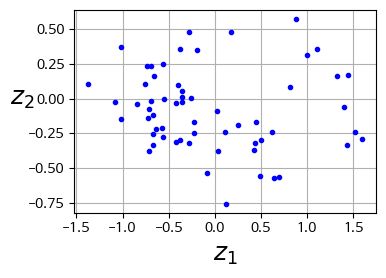

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## 17.3 적층 오토인코더

오토인코더는 은닉 층을 여러 개 쌓아 더 복잡한 코딩을 학습할 수 있는데, 이를 **적층 오토인코더** 또는 **심층 오토인코더**라고 합니다. 

층이 많아질수록 더욱 복잡한 데이터를 표현할 수 있지만, 오토인코더가 너무 강력해져서 각 입력을 특정 숫자로만 매핑하게 되면 훈련 데이터를 잘 재구성하더라도 유용한 데이터 표현을 학습하지 못하게 됩니다.

적층 오토인코더의 구조는 코딩 층을 중심으로 대칭적이며, 예를 들어 패션 MNIST 데이터의 경우, 입력 층과 출력 층에 각각 784개의 뉴런이 있고, 중간에 100개와 30개의 뉴런을 가진 은닉 층들이 위치해 샌드위치 모양을 형성합니다.

<img src="./images/fig17-03.png" width="100%"></img>

### 17.3.1 케라스를 사용하여 적층 오토인코더 구현하기

패션 MNIST 데이터셋을 로드하고 크기를 조정한 다음 훈련 세트, 검증 세트, 테스트 세트로 분할해 보겠습니다:

In [12]:
# 추가 코드 - 패션 MNIST 데이터셋 로드, 스케일링 및 분할
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

3개의 은닉 층과 1개의 출력 층으로 구성된 적층 오토인코더를 만들고 훈련해 보겠습니다.

이 코드를 하나씩 살펴봅시다. 여기서도 오토인코더 모델을 인코더와 디코더 두 개 서브 모델로 나눕니다.

- 인코더는 28X28 픽셀의 흑백 이미지를 받습니다. 그다음 각 이미지를 784 크기의 벡터로 표현하기 위해 펼칩니다. 이 벡터를 크기가 점점 줄어드는 （100개 유닛 다음에 30개 유닛을 가진） Dense 층 두 개에 통과시킵니다. 두 층은 모두 ReLU 활성화 함수를 사용합니다. 각 입력 이미지에 대해 인코더는 크기가 30인 벡터를 출력합니다.

- 디코더는 （인코더가 출력한） 크기가 30인 코딩을 받습니다. 그다음 크기가 점점 커지는 （100개 유닛 다음에 784개 유닛을 가진） Dense 층 두 개에 통과시킵니다. 최종 벡터를 28x28 배열로 변경하여 디코더의 출력이 인코더의 입력과 동일한 크기가 되도록 만듭니다.

- 적층 오토인코더를 컴파일할 때 평균 MSE 손실과 nadam 옵티마이저를 사용합니다.

- 마지막으로 X_train을 입력과 타깃으로 사용해 모델을 훈련합니다. 비슷하게 X_valid를 검증 입력과 검증 타깃으로 사용합니다

In [13]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0241 - val_loss: 0.0194
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0174 - val_loss: 0.0168
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 7/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 8/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 10/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.013

### 17.3.2 재구성 시각화하기

이 함수는 몇 가지 검증 이미지를 오토인코더에 통과시키고 원본 이미지와 재구성된 이미지를 표시합니다:

오토인코더가 적절히 훈련되었는지 확인하는 한 가지 방법은 입력과 출력을 비교하는 것입니다. 

즉, 입력과출력의 차이가 너무 크지 않아야합니다. 검증 세트에서 원본 이미지 몇 개를 재구성된 것과 함께 그려봅시다.

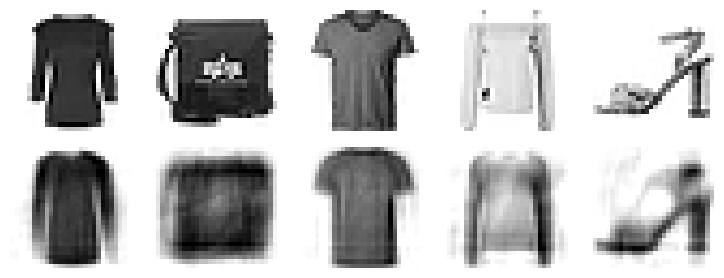

In [14]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # 추가 코드 - 고해상도 그림 저장
plt.show()

<img src="./images/fig17-04.png" width="100%"></img>

재구성된 이미지가 흐릿해 보이지만 784개가 아닌 30개의 숫자로 압축되었다는 점을 기억하세요.  

재구성된 이미지를 식별할 수는 있지만 정보를 조금 많이 잃었습니다.  
모델을 더 오래 훈련하거나, 인코더와 디코더의 층을 늘리거나, 코딩의 크기를 늘려야 할지 모릅니다. 하지만 네트워크가 너무 강력하면 데이터에서 유익한 패턴을 학습하지 못하고 완벽한 재구성 이미지를 만들 것입니다. 일단은 이 모델을 사용해보겠습니다

### 17.3.3 패션 MNIST 데이터셋 시각화하기

적층 오토인코더는 데이터셋의 차원을 줄일 수 있지만, 시각화에 있어 다른 차원 축소 알고리즘만큼 최적의 결과를 제공하지는 않습니다. 

그러나 오토인코더는 대용량 데이터셋을 처리하는 데 강점이 있기 때문에, 먼저 오토인코더로 차원을 축소한 후 다른 차원 축소 알고리즘으로 추가 축소 및 시각화를 할 수 있습니다. 

이 방식으로 패션 MNIST 데이터셋을 시각화해보죠. 먼저 적층 오토인코더의 인코더 모델을 사용해 차원을 30으로 줄입니다. 

그다음 t-SNE알고리즘을 구현한 사이 킷런 클래스로 시각화를 위해 차원을 2까지 줄이겠습니다

In [15]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

d:\00_Python_Projects\01_Study\user_ds4th_study\source\핸즈온_머신러닝\.tensor0\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


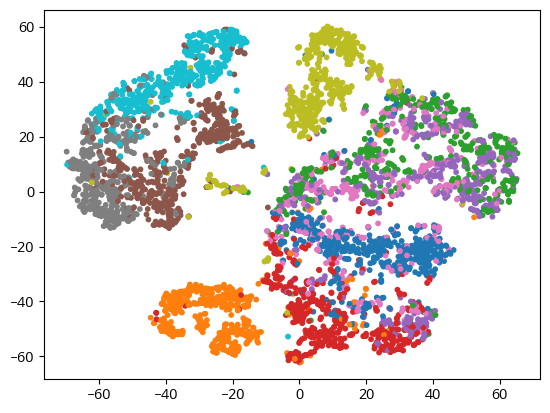

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

이 다이어그램을 좀 더 예쁘게 만들어 봅시다
(이 [Scikit-Learn 예제](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)를 참고했습니다):

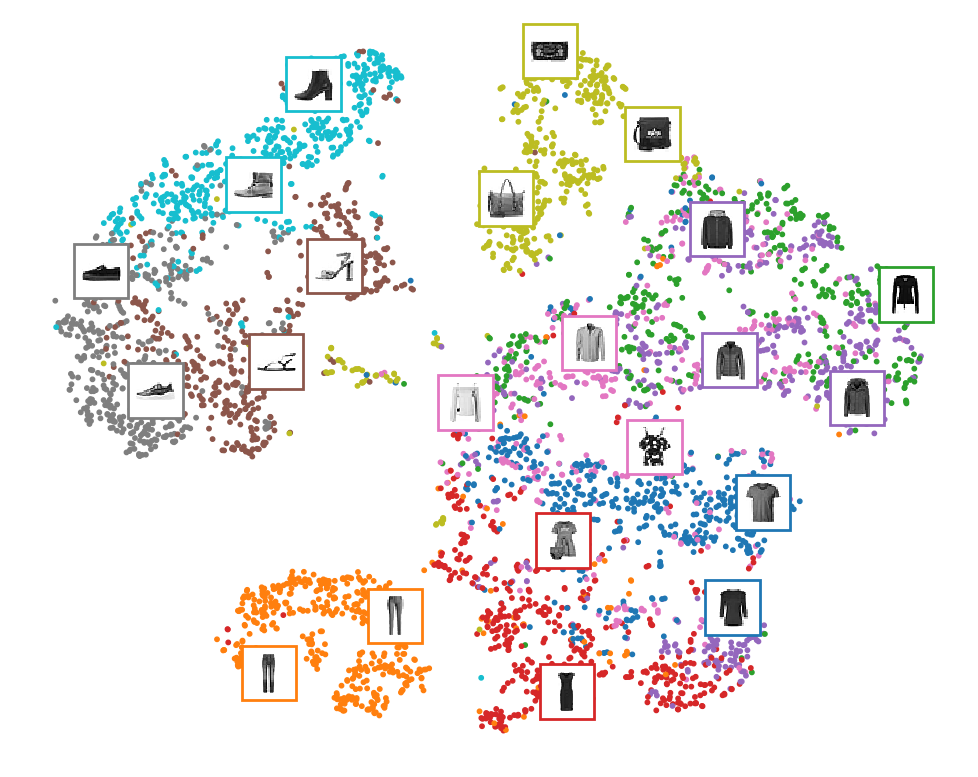

In [17]:
# 추가 코드 - 이전 그래프를 아름답게 꾸밉니다.

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # 0-1 범위로 정규화
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # 다른 이미지와 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

이렇게 오토인코더를 차원 축소에 사용할 수 있습니다. 다음으로 비지도 사전 훈련에 적용해보겠습니다

<img src="./images/fig17-05.png" width="100%"></img>

### 17.3.4 적층 오토인코더를 사용한 비지도 사전 훈련

복잡한 지도 학습 문제에서 레이블된 데이터가 적을 경우, 유사한 문제를 학습한 신경망의 하위 층을 재사용하면 유리합니다. 이를 통해 저수준의 특성을 재학습할 필요가 없으므로 적은 데이터로도 효과적인 모델을 만들 수 있습니다.

**마찬가지로 대규모의 레이블 없는 데이터셋이 있을 때, 먼저 이 데이터를 사용해 적층 오토인코더를 훈련한 후, 오토인코더의 하위 층을 재사용해 실제 문제를 해결하는 신경망을 만들 수 있습니다.**

예를 들어, 
- 분류 신경망을 만들 때 사전 훈련된 오토인코더의 하위 층을 사용해 비지도 학습으로 특성 감지를 수행하고, 
- 이후 레이블된 데이터로 훈련을 진행하면 좋습니다. 
- 특히 레이블 데이터가 부족할 때는 하위 층을 고정(동결)하는 것이 도움이 됩니다.

<img src="./images/fig17-06.png" width="100%"></img>

### 17.3.5 가중치 묶기

방금 만든 것처럼 오토인코더가 완벽히게 대칭일 땐 디코더의 가중치와 인코더의 가중치를 묶는 것이 일반적인 방법입니다.  
이렇게 하면 모델에 있는 가중치의 수가 절반으로 줄어들어 훈련 속도가 증가하고 과대적합의 위험이 줄어듭니다.  
이를 위해서는 사용자 정의 층을 사용해야 합니다.

대칭적인 오토인코더에서는 디코더의 가중치를 인코더의 가중치와 공유하는 방식이 일반적입니다. 이를 통해 모델 가중치의 수를 줄이고 훈련 속도를 높일 수 있으며, 과대적합 위험도 감소시킬 수 있습니다. 예를 들어, $L$개의 층을 가진 오토인코더에서 $W_L$이 $L$번째 층의 가중치라면, 디코더 층의 가중치는 $W_i = W_{N-i+1}^T $로 정의됩니다.

케라스를 사용해 사용자 정의 층을 만들고, 이렇게 가중치를 공유하는 구조를 구현할 수 있습니다.

In [18]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

이 사용자 정의 층은 일반적인 Dense 층과 다른 Dense 층의 전치된 가중치를 사용합니다. transpose_b=True로 지정하는 것이 두 번째 매개변수를 전치하는 것과 동일하지만 matmul() 연산에서 동적으로 전치를 수행하므로 훨씬 효율적입니다）. 

그리고 독자적인 편향 벡터를 사용합니다. 그런 다음 이전과 비슷하게 새로운 적층 오토인코더를 만듭니다. 이 디코더의 Dense 층은 인코더의 Dense 층과 묶여있습니다

In [19]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0246 - val_loss: 0.0189
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0168 - val_loss: 0.0161
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 10/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.013

이 모델은 거의 절반의 파라미터로 이전 모델보다 약간 낮은 재구성 오차를 달성합니다.

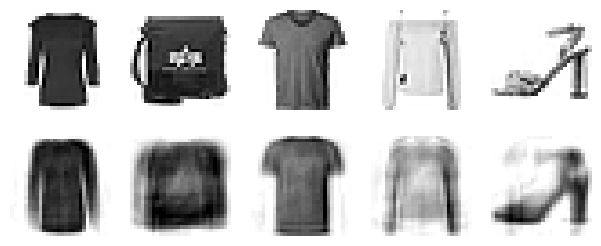

In [20]:
# 추가 코드 - 플롯 재구성
plot_reconstructions(tied_ae)
plt.show()

### 17.3.6 오토인코더 한 개씩 훈련하기

<img src="./images/fig17-07.png" width="100%"></img>

앞서 만들었던 것처럼 한 번에 전체 오토인코더를 훈련하는 대신, [그림 17-7]처럼 오토인코더 하나를 훈련하고 이를 쌓아올려서 한 개의 적층 오토인코더를 만들 수 있습니다. 이런 방식은 요즘엔 많이 사용하지 않지만, ‘탐욕적 방식의 층별 훈련(layerwise training)’에 관한 논문에는 여전히 등장하므로 알아두는 것이 좋습니다.

##### 단계별 훈련 과정
1. **단계 1**: 첫 번째 오토인코더를 훈련하여 입력을 재구성하도록 합니다.

2. **단계 2**: 이 첫 번째 오토인코더를 사용해 전체 훈련 세트를 인코딩하여 압축된 새 훈련 세트를 만듭니다. 

3. 두 번째 오토인코더를 훈련시킵니다.

4. **단계 3**: 모든 오토인코더를 사용해 전체 네트워크를 만들고, 각 오토인코더의 은닉 층을 먼저 쌓고 출력 층을 반대로 쌓아 최종 적층 오토인코더를 완성합니다.

이 과정을 통해 더 많은 오토인코더를 훈련해 매우 깊은 적층 오토인코더를 만들 수 있습니다.

2006년 제프리 힌턴 등이 탐욕적인 층별 접근 방법을 사용해 심층 신경망을 비지도 학습으로 사전 훈련할 수 있음을 발견했으며, 이를 위해 제한된 볼츠만 머신(RBM)을 사용했습니다. 2007년에는 요슈아 벤지오 등이 이 방식을 오토인코더에도 적용할 수 있음을 보였습니다. 심층 신경망을 효율적으로 훈련하기 전까지 이 방식은 유일한 방법으로 사용되었습니다.


추가 자료 - 한 번에 하나씩 오토인코더 훈련하기

In [21]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [22]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0202 - val_loss: 0.0130
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0095
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 10/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.008

In [23]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

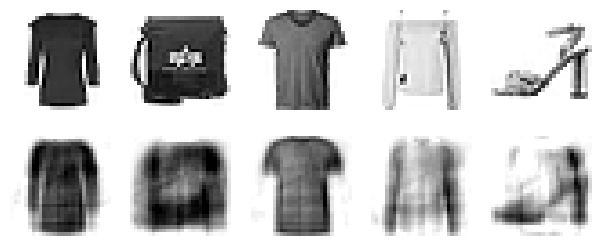

In [24]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

필요한 경우 전체 적층 오토인코더를 몇 에포크 동안 계속 학습할 수 있습니다:

In [25]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0171 - val_loss: 0.0159
Epoch 2/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0150 - val_loss: 0.0145
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 5/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0132 - val_loss: 0.0132


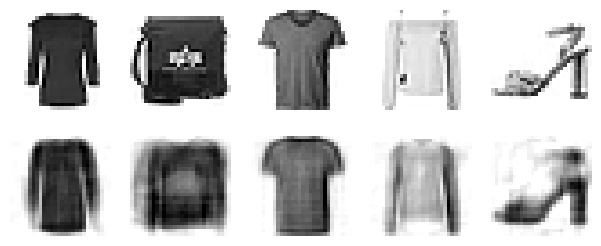

In [26]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## 17.4 합성곱 오토인코더

이미지를 다룰 때는 오토인코더가 좋은 성능을 내지 못하는 경우가 많습니다. 14장에서 본 것처럼, 이미지를 다룰 때는 **합성곱 신경망 CNN**이 밀집 네트워크보다 훨씬 더 효율적입니다. 따라서 이미지에 대한 오토인코더를 만들려면 **합성곱 오토인코더**(Convolutional Autoencoders)를 만들어야 합니다.

합성곱 오토인코더 구성
1. **인코더**:
   - 합성곱 층(CNN)과 풀링 층으로 구성됩니다.
   - 전형적으로 입력에서 공간 방향의 차원(높이와 너비)을 줄이고, 깊이(특성 맵의 개수)를 늘립니다.

2. **디코더**:
   - 인코더의 작동과 반대로 이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌립니다.
   - 이를 위해 **전치 합성곱 층**을 사용하거나, **합성곱 층**과 **업샘플링 층**을 연결할 수 있습니다.

다음은 **패션 MNIST** 데이터셋에 대한 간단한 합성곱 오토인코더 예시입니다.


3개의 은닉 층과 1개의 출력 층으로 구성된 적층 오토인코더를 만들어 보겠습니다.

In [27]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # 출력: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0338 - val_loss: 0.0232
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0211 - val_loss: 0.0189
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 9/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 10/10
1719/1719 [==============================] - 10s 6ms/step - l

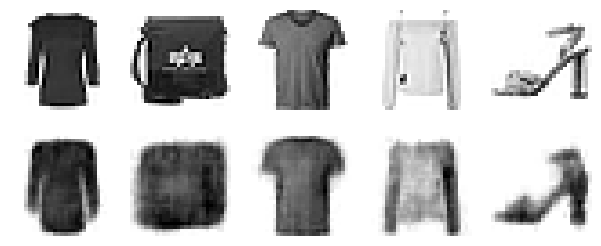

In [28]:
# 추가 코드 - 재구성을 표시합니다.
plot_reconstructions(conv_ae)
plt.show()

RNN과 같은 다른 구조를 사용해 오토인코더를 만들 수도 있습니다(주피터 노트북 참고).

지금까지 다룬 오토인코더 종류 및 훈련 방법
- **기본 오토인코더**: 입력 데이터를 재구성하는 모델.
- **적층 오토인코더**: 여러 개의 오토인코더를 쌓아서 더 복잡한 표현을 학습하는 모델.
- **합성곱 오토인코더**: 이미지 데이터와 같은 공간적 특성을 다룰 때 효과적인 오토인코더.

훈련 방법
- **한 번에 훈련**: 전체 오토인코더를 한 번에 훈련하는 방식.
- **층별 훈련**: 각 층을 순차적으로 훈련하여 오토인코더를 구축하는 방식.

데이터 시각화 및 비지도 사전 훈련
- 오토인코더를 사용해 데이터의 차원을 축소하고, 비지도 방식으로 사전 훈련을 수행할 수 있습니다.

제약을 통해 오토인코더의 특성 학습
- **과소완전**: 코딩 층의 크기를 제한하여 특성 학습을 강제.
- **과대완전**: 입력 크기와 같거나 더 큰 코딩 층을 두어 과대완전 오토인코더를 만들 수 있습니다.

다음 절에서는 **잡음 제거 오토인코더**, **희소 오토인코더**, **변이형 오토인코더**와 같은 다양한 오토인코더 모델에 대해 살펴봅니다.

### 추가 자료 - 순환 오토인코더

각 패션 MNIST 이미지를 각각 28개의 차원을 가진 28개의 벡터 시퀀스로 취급해 보겠습니다:

In [29]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [30]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.0293 - val_loss: 0.0209
Epoch 2/10
1719/1719 [==============================] - 53s 31ms/step - loss: 0.0190 - val_loss: 0.0171
Epoch 3/10
1719/1719 [==============================] - 46s 27ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 4/10
1719/1719 [==============================] - 52s 30ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 5/10
1719/1719 [==============================] - 47s 28ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 6/10
1719/1719 [==============================] - 43s 25ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 7/10
1719/1719 [==============================] - 47s 27ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 8/10
1719/1719 [==============================] - 52s 30ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 9/10
1719/1719 [==============================] - 47s 27ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 10/10
1719/1719 [==============================] - 51s 29m

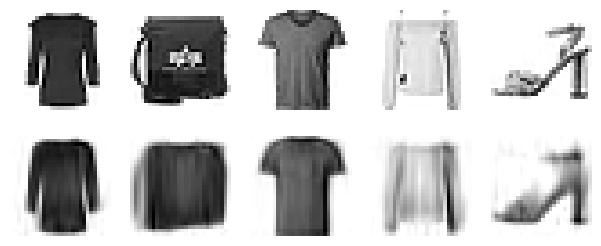

In [31]:
plot_reconstructions(recurrent_ae)
plt.show()

## 17.5 잡음 제거 오토인코더

오토인코더가 유용한 특성을 학습하도록 강제하는 또 다른 방법은 **입력에 잡음을 추가**하고, 잡음이 없는 원본 입력을 복원하도록 훈련하는 것입니다. 이 아이디어는 1980년대부터 존재했으며, 예를 들어 **얀 르쿤**의 1987년 석사 논문에 언급되었습니다. 또한 **파스칼 빈센트**는 2008년 논문에서 오토인코더를 특성 추출기로 사용할 수 있음을 보였고, 2010년 논문에서 **적층 잡음 제거 오토인코더 Denoising Autoencoder**를 소개했습니다.

잡음 추가 방법
- **가우시안 잡음**: 입력에 순수한 가우시안 잡음을 추가하여 잡음을 만든다.
- **드롭아웃**: 입력에서 랜덤으로 일부를 끄는 방식으로 잡음을 생성한다.

구현 방법
- **Dropout 층** 또는 **GaussianNoise 층**을 사용하여 입력에 잡음을 추가합니다.
- Dropout 층은 훈련 중에만 활성화되며, GaussianNoise 층도 마찬가지로 훈련 동안만 작동합니다.

이 방법은 오토인코더가 입력 데이터의 중요한 특성만을 학습하도록 유도하는 데 유용합니다.


<img src="./images/fig17-08.png" width="100%"></img>

드롭아웃 사용:

In [32]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0290 - val_loss: 0.0220
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0223 - val_loss: 0.0200
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0209 - val_loss: 0.0191
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0202 - val_loss: 0.0186
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0197 - val_loss: 0.0181
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0193 - val_loss: 0.0179
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0188 - val_loss: 0.0172
Epoch 9/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 10/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.018

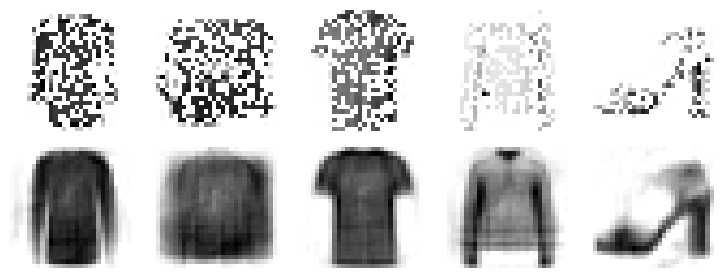

In [33]:
# 추가 코드 - 이 셀은 그림 17-9를 생성하고 저장합니다.
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

<img src="./images/fig17-09.png" width="100%"></img>

**잡음 제거 오토인코더 예시**

위의 이미지는 **픽셀 절반을 꺼서 만든 잡음 섞인 이미지**와 **드롭아웃 기반의 잡음 제거 오토인코더**로 재구성한 이미지입니다. 두 번째 행의 네 번째 이미지에서 **흰색 셔츠의 목 부분**처럼, 오토인코더는 실제 입력에 없었던 상세 정보를 **예측**하는 방식으로 복원합니다. 이 예시는 오토인코더가 이미지에서 **잡음을 제거**하고 중요한 특성만을 학습하는 방법을 보여줍니다.

이처럼 **잡음 제거 오토인코더**는 단순한 데이터 시각화나 비지도 사전 훈련뿐만 아니라, **이미지에서 잡음을 제거**하는 데 매우 유효하고 효율적으로 사용될 수 있습니다.

원하는 경우 `Dropout` 레이어를 `tf.keras.layers.GaussianNoise(0.2)`로 교체해 볼 수 있습니다.

## 17.6 희소 오토인코더

#### 희소 오토인코더 (Sparse Autoencoder)
**희소 오토인코더**는 비용 함수에 특정 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런의 수를 감소시키도록 만드는 방법입니다. 예를 들어, 코딩 층에서 **평균적으로 5%**의 뉴런만 활성화되도록 강제할 수 있습니다. 이렇게 하면 오토인코더는 **적은 수의 활성화된 뉴런**을 조합하여 입력을 표현하게 되며, 각 뉴런은 **유용한 특성**을 나타내게 됩니다. 이는 마치 "한 달에 몇 마디만 말할 수 있다면 꼭 필요한 말만 하게 되는" 상황과 비슷합니다.

#### 활성화 함수와 규제
코딩 층에 **시그모이드 활성화 함수**를 사용하고, 코딩 층의 활성화 값에 **활성화 규제**(Activity Regularization)를 추가하여 이를 구현할 수 있습니다. 이 규제는 신경망이 **0에 가까운 코딩**을 생성하도록 유도합니다. 그러나 입력을 올바르게 재구성하지 못할 경우 벌칙을 받게 되므로 **0이 아닌 값**이 최소한 출력되도록 해야 합니다.

- **활성화 규제**는 **ActivityRegularization** 층을 사용하여 구현할 수 있습니다. 이 층은 입력을 그대로 반환하면서, 훈련 손실에 **입력의 절댓값 합**을 추가합니다.

#### 희소 정도 규제
훈련 반복마다 **코딩 층의 실제 희소 정도**를 측정하고, **타깃 희소 정도**와 다를 경우 모델에 벌칙을 부과하는 방법도 있습니다. 이 방식은 다음과 같이 동작합니다:

1. **훈련 배치**에 대해 코딩 층의 각 뉴런의 **평균 활성화**를 계산합니다.
2. 이 값을 바탕으로 **희소 손실**(sparsity loss)을 비용 함수에 추가하여, 너무 많이 활성화된 뉴런이나 충분히 활성화되지 않은 뉴런에 벌칙을 가합니다.

예를 들어, 한 뉴런의 평균 활성화가 **0.3**이고 목표 희소도가 **0.1**이라면, 이 뉴런이 덜 활성화되도록 **규제**해야 합니다. 이를 위해 **제곱 오차**를 비용 함수에 추가하거나, **쿨백-라이블러 발산**(Kullback-Leibler Divergence)을 사용하여 더 나은 결과를 얻을 수 있습니다.

- **쿨백-라이블러 발산**은 평균 제곱 오차보다 훨씬 강한 그레이디언트를 가지며, **효율적인 규제** 방법입니다.


코딩 레이어에서 시그모이드 활성화 함수를 사용해 보겠습니다. 여기에 $\ell_1$ 정규화도 추가해 보겠습니다: 이를 위해 코딩 층 뒤에 `ActivityRegularization` 층을 추가합니다. 또는 코딩 층 자체에 `activity_regularizer=tf.keras.regularizers.l1(1e-4)`를 추가할 수도 있습니다.

In [34]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0295 - val_loss: 0.0208
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 8/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 9/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 10/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.011

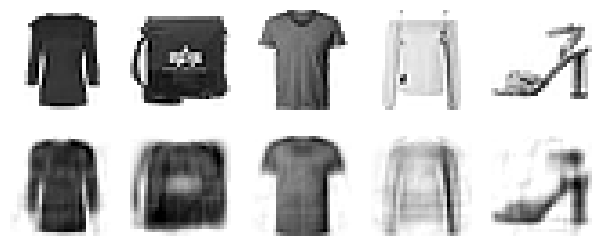

In [35]:
# 추가 코드 - 재구성을 표시합니다.
plot_reconstructions(sparse_l1_ae)
plt.show()

KL 발산 손실과 MAE 및 MSE를 비교하여 그래프를 그려 보겠습니다:

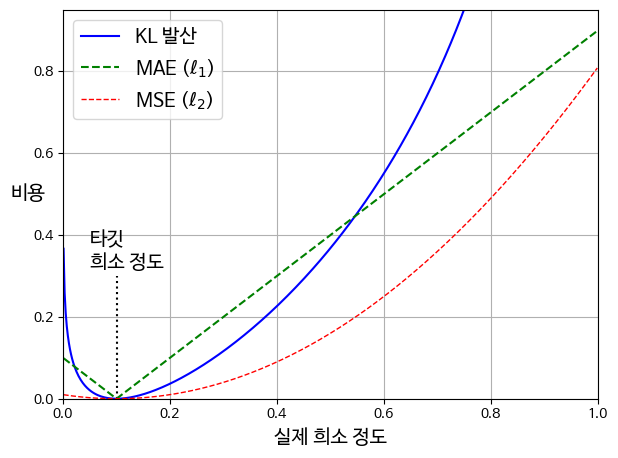

In [36]:
# 추가 코드 - 이 셀은 그림 17-10을 생성하고 저장합니다.
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "타깃\n희소 정도", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL 발산")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("실제 희소 정도")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

<img src="./images/fig17-10.png" width="100%"></img>

### 쿨백-라이블러(KL) 발산을 이용한 희소 오토인코더
두 개의 이산 확률 분포 **P**와 **Q**가 주어졌을 때, 이 두 분포 사이의 **쿨백-라이블러(KL) 발산** $ D_{KL}(P \parallel Q) $은 다음과 같은 식으로 계산할 수 있습니다:

#### KL 발산 식:
$
D_{KL}(P \parallel Q) = \sum p(i) \log \left( \frac{p(i)}{q(i)} \right)
$

여기서, **P**는 목표 확률 분포이고 **Q**는 실제 확률 분포입니다. 이 식을 바탕으로 코딩 층에서 뉴런의 활성화 목표 확률 **p**와 실제 확률 **q** 사이의 KL 발산을 계산할 수 있습니다.

### 목표 희소도와 실제 희소도의 KL 발산
코딩 층의 뉴런에 대한 목표 희소도 **p**와 실제 희소도 **q** 사이의 KL 발산은 다음과 같이 계산됩니다:

#### KL 발산 식 (희소도 기준):
$
D_{KL}(p \parallel q) = p \log \left( \frac{p}{q} \right) + (1 - p) \log \left( \frac{1 - p}{1 - q} \right)
$

### 희소 손실 계산
각 뉴런에 대해 계산된 KL 발산은 **희소 손실**(sparsity loss)로, 비용 함수의 일부로 추가됩니다. 이 희소 손실의 상대적 중요도는 **희소 가중치** 하이퍼파라미터로 조정할 수 있습니다. 이 가중치가 너무 크면 모델이 목표 희소도에 가까워지지만 **재구성 손실**을 제대로 최소화하지 못할 수 있습니다. 반대로, 가중치가 너무 작으면 모델이 희소 목표를 무시하고 **흥미로운 특성**을 학습하지 못하게 됩니다.

### KL 발산 규제를 적용한 사용자 정의 규제
KL 발산을 기반으로 한 희소 오토인코더를 구현하려면, 먼저 **KL 발산 규제**를 적용할 수 있는 사용자 정의 규제를 만들어야 합니다.


KL-발산 규제를 위한 사용자 정의 클래스를 정의해 보겠습니다:

In [37]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

이제 이 규제를 사용하여 코딩 층에서 모델의 희소 정도가 약 10%가 되도록 해 보겠습니다:

In [38]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0272 - val_loss: 0.0185
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0167 - val_loss: 0.0149
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.009

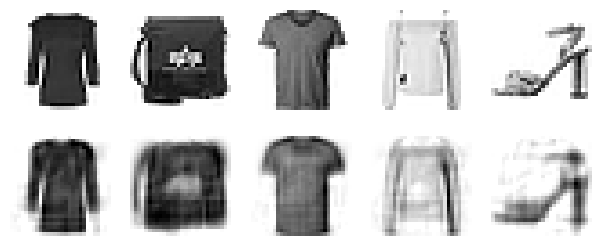

In [39]:
# 추가 코드 - 재구성을 표시합니다.
plot_reconstructions(sparse_kl_ae)
plt.show()

## 17.7 변이형 오토인코더

#### 변이형 오토인코더(Variational Autoencoder, VAE)

변이형 오토인코더(VAE)는 기존의 오토인코더와 다르게 **확률적**이고 **생성적인** 모델입니다. 즉, 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정되며, 새로운 데이터를 생성할 수 있는 능력을 가지고 있습니다.

#### VAE의 주요 특징
1. **확률적 오토인코더**: 훈련 후에도 출력이 우연히 결정됩니다.
2. **생성 오토인코더**: 훈련된 모델을 사용하여 새로운 샘플을 생성할 수 있습니다.
3. **변분 베이지안 추론(Variational Bayesian Inference)**을 사용하여 확률 분포를 근사하고 샘플을 생성합니다.

이런 두 속성이 변이형 오토인코더를 RBM과 유사하게 만듭니다. 히지만 훈련이 더 쉽고 샘플 
링 과정이 훨씬 빠릅니다（RBM에서는 새로운 샘플을 만들기 전에 네트워크가 ‘열평형’ 상태로 
안정될 때까지 기다려야 합니다）. 

이름에서 알 수 있듯이 변이형 오토인코더는 효율적인 근사 베이즈 추론 빙법인 변분 베이즈 추론 variational Bayesian inference을 수행합니다. 베이즈 추론은 베이즈 정리에서 유도된 방정식을 사용하여 새로운 데이터를 기반으로 확률 분포를 업데이트하는 것을 의미합니다. 

원래 분포를 **사전 분포**라고 하고 업데이트된 분포를 **사후 분포**라고 합니다. 이 경우 데이터 분포의 좋은 근삿값을 찾는 것이 목적입니다. 근삿값을 찾으면 이로부터 샘플을추출할 수 있습니다.

#### VAE 구조
1. **인코더(Encoder)**: 입력을 받아 평균(mean)과 표준편차(standard deviation)를 예측하고, 이를 바탕으로 잠재 변수(latent variable)를 샘플링합니다.
2. **디코더(Decoder)**: 샘플링된 잠재 변수를 입력으로 받아 원래 입력을 재구성합니다.

<img src="./images/fig17-11.png" width="100%"></img>

#### 비용 함수
VAE의 비용 함수는 두 가지 손실로 구성됩니다:
- **재구성 손실(Reconstruction Loss)**: 입력 데이터를 얼마나 잘 복원하는지를 측정합니다.
- **잠재 손실(Latent Loss)**: 실제 분포와 목표 분포(가우스 분포) 간의 KL 발산(KL Divergence)을 측정합니다.

#### 잠재 손실 공식
- **식 17-3**:
  $
  \text{Latent Loss} = -\frac{1}{2} \sum_{i=1}^{L} \left( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)
  $

<img src="./images/eq17-03.png" width="100%"></img>
  
  여기서 $ \mu $는 평균, $ \sigma^2 $는 분산을 나타내며, $ L $은 코딩 벡터의 차원입니다.

#### 변이형 오토인코더 구현

변이형 오토인코더를 구현하기 위한 기본적인 단계는 다음과 같습니다:
1. **인코더**: 평균과 로그 분산을 출력하는 두 개의 Dense 층을 사용합니다. 이를 바탕으로 샘플링하여 잠재 변수를 생성합니다.

2. **디코더**: 잠재 변수를 받아서 원래 입력을 재구성합니다.

3. **손실 함수**: 재구성 손실과 잠재 손실을 더하여 최종 손실을 계산합니다.


<img src="./images/eq17-04.png" width="100%"></img>

#### 사용자 정의 샘플링 층
잠재 변수 샘플링은 평균과 로그 분산을 받아서, 이를 바탕으로 가우스 분포에서 샘플링한 값을 반환하는 사용자 정의 층을 통해 수행됩니다.


패션 MNIST 데이터셋을 사용하여 변이형 오토인코더를 구현하려면, 먼저 **평균(mean)**과 **로그 분산(log-variance)**을 바탕으로 잠재 변수(coding)를 샘플링하는 사용자 정의 샘플링 층을 만들어야 합니다. 이 층은 주어진 평균과 로그 분산을 이용해 가우시안 분포에서 샘플을 생성하여, 모델의 잠재 공간(latent space)을 확립하는 역할을 합니다.

In [40]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

이 Sampling 층은 mean(p)와 log_var(y)를 입력으로 받습니다. 그 후, tf.random_normal() 함수를 사용하여 평균이 0이고 표준 편차가 1인 정규 분포에서 크기가 동일한(7과 동일한 크기) 랜덤 벡터를 생성합니다. 이후, 이 벡터에 표준 편차 (exp(0.5 * log_var))를 곱하고 평균 (mean)을 더하여, 평균이 mean이고 표준 편차가 exp(0.5 * log_var)인 정규 분포에서 샘플링된 잠재 변수(latent variable)를 생성합니다. 이 샘플링된 잠재 변수가 이후 디코더로 전달되어 최종 출력을 생성하게 됩니다.

이 샘플링된 벡터는 이후 표준 편차 (exp(y / 2))를 곱하고 평균 (mean)을 더한 결과로 반환됩니다. 이렇게 하면 평균이 M이고 표준 편차가 o인 정규 분포에서 코딩 벡터가 샘플링됩니다.

이 모델은 순차적이지 않기 때문에, 함수형 API를 사용해 인코더를 구현합니다. 함수형 API를 사용하면 네트워크의 복잡한 연결 구조를 보다 유연하게 표현할 수 있습니다.

In [41]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

이 과정에서는 두 개의 Dense 층을 사용하여 codings_mean과 codings_log_var를 출력합니다. 두 번째 Dense 층의 출력이 동일하게 사용됩니다. 그런 다음, codings_mean과 codings_log_var는 Sampling 층으로 전달되어 실제 코딩 벡터가 샘플링됩니다.

이후, variational_encoder 모델은 세 개의 출력을 생성하는데, 필요한 출력은 codings이지만, 디버깅을 위해 codings_mean과 codings_log_var도 출력됩니다.

이제 모델의 디코더를 구축해야 합니다. 디코더는 변이형 오토인코더의 출력인 codings를 다시 입력으로 받아 원본 데이터 형태로 복원하는 역할을 합니다.

In [42]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

디코더는 시퀀셜 API를 사용하여 구현할 수도 있습니다. 시퀀셜 API는 모델을 층별로 쌓는 방식으로, 이전에 구축한 다른 디코더 모델과 유사하게 층을 쌓는 형태입니다.

디코더의 구현 과정:
층 쌓기: 시퀀셜 API를 사용하여, 디코더는 codings를 입력으로 받고, 원본 데이터 형태로 복원하는 여러 층을 순차적으로 쌓습니다.
변이형 오토인코더 모델: 모델을 최종적으로 구성하는 과정입니다. 이 모델은 인코더의 codings만 디코더에 주입하고, 출력이 원본 데이터와 유사하도록 학습됩니다.
최종적으로, 변이형 오토인코더 모델을 만들어 훈련할 준비가 완료됩니다.

In [43]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

변이형 오토인코더에서 인코더의 처음 두 출력을 무시하고, 코딩만 디코더에 주입하는 과정은 다음과 같습니다:

인코더의 출력:

인코더는 평균(mean)과 로그 분산(log_var)을 출력합니다.
이 두 출력 중에서 코딩만 디코더에 전달됩니다. 이는 Sampling 층을 통해 샘플링된 잠재 변수(latent variable)입니다.
잠재 손실과 재구성 손실 추가:

잠재 손실: 인코더에서 출력된 잠재 벡터가 가우시안 분포에서 샘플링된 것처럼 보이도록 하는 손실입니다. 이는 KL 발산(Kullback-Leibler Divergence)을 사용하여 계산됩니다.
재구성 손실: 디코더가 생성한 출력이 입력과 유사하도록 만드는 손실입니다. 일반적으로 MSE(Mean Squared Error)를 사용합니다.
모델 훈련 과정에서:
잠재 손실은 코딩 벡터가 잠재 공간에서 규칙적으로 분포하도록 유도합니다.
재구성 손실은 디코더가 입력을 정확하게 복원하도록 돕습니다.
이 두 손실을 최종 비용 함수에 합산하여 모델을 훈련시킵니다.

In [44]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

[식 17-4] 를 적용해 마지막 축을 따라 더해서 배치에 있는 각 샘플의 잠재 손실을 계산합니다. 
그다음 배치에 있는 모든 샘플의 평균 손실을 계산하고 재구성 손실에 비례해 적절한 크기가 
되도록 784로 나눕니다. 실제로 변이형 오토인코더의 재구성 손실은 픽셀마다 재구성 오차의 
합입니다. 

하지만 케라스가 mse 손실을 계산할 때 합이 이니라 784개 전체 픽셀의 평균을 계산 
합니다. 따라서 핀요한 것보다 재구성 손실이 784배 작습니다. 평균이 이니라 합을 계산하는 
사용자 정의 손실 함수를 정의할 수 있지만 잠재 손실을 784로 나누는 것이 더 간단합니다（최 
종 손실은 원래보다 784배 작아질 것입니다. 이는 더 큰 학습률을 사용해야 한다는 것을 의미 
합니다）.

마지막으로 이 오토인코더를 컴파일하고 훈련합니다!

In [45]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 2s 6ms/step - loss: 0.0513 - val_loss: 0.0404
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0377 - val_loss: 0.0374
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0356 - val_loss: 0.0351
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0346 - val_loss: 0.0343
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0338 - val_loss: 0.0338
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0333 - val_loss: 0.0334
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0329 - val_loss: 0.0331
Epoch 8/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0327 - val_loss: 0.0328
Epoch 9/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0324 - val_loss: 0.0325
Epoch 10/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0322 - val_loss: 0.0325

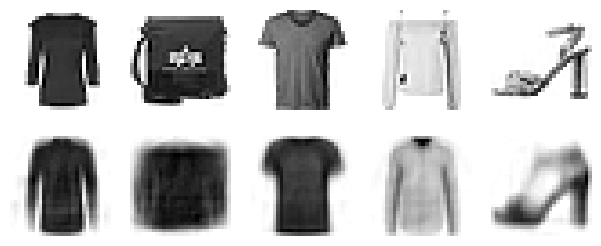

In [47]:
plot_reconstructions(variational_ae)
plt.show()

### 17.7.1 패션 MNIST 이미지 생성하기

이 변이형 오토인코더를 사용해 패션 의류처럼 보이는 이미지를 생성해보겠습니다. 해야 할 일 
은 가우스 분포에서 랜덤한 코딩을 샘플링하여 디코딩하는 것이 전부입니다.

In [48]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

이제 이 이미지를 출력해 보겠습니다:

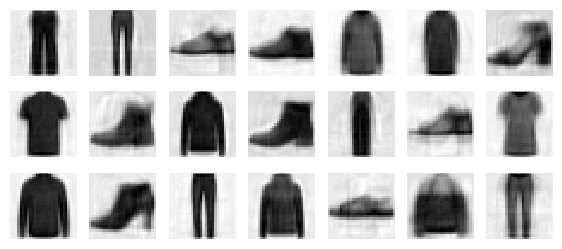

In [49]:
# 추가 코드 - 이 셀은 그림 17-12를 생성하고 저장합니다.

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

<img src="./images/fig17-12.png" width="100%"></img>

이제 두 이미지 사이에 시맨틱 보간을 수행해 보겠습니다:

#### 변이형 오토인코더의 시맨틱 보간

변이형 오토인코더는 **시맨틱 보간(semantic interpolation)** 기능을 제공할 수 있습니다. 이는 **픽셀 수준**에서 이미지를 보간하는 대신, **잠재 공간(latent space)**에서 이미지를 보간하는 방식입니다.

#### 시맨틱 보간:
1. **잠재 공간에서 보간**:
   - 두 이미지의 잠재 벡터(코딩)를 연결하여 그 사이에서 보간을 수행합니다. 즉, 두 이미지가 가진 잠재 벡터의 차이를 따라 여러 중간 값을 생성하고, 이를 디코더로 통과시켜 새로운 이미지를 만듭니다.

2. **결과**:
   - 이 방식으로 생성된 이미지는 두 이미지가 **겹쳐 보이는** 듯한 자연스러운 전환을 나타냅니다. 이는 픽셀 단위의 보간보다 더 의미론적인, 즉 시맨틱한 보간을 수행하는 것입니다.

변이형 오토인코더는 학습이 빠르고 효율적이기 때문에 몇 분의 학습만으로도 이와 같은 보간 기능을 수행할 수 있다는 점에서 매우 강력한 도구입니다.


In [50]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # 이 경우 축 3이 가장 좋습니다.
images = variational_decoder(codings).numpy()

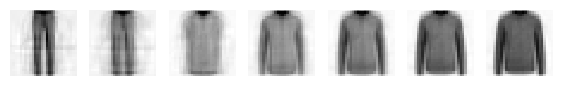

In [51]:
# 추가 코드 - 이 셀은 그림 17-13을 생성하고 저장합니다.
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

<img src="./images/fig17-13.png" width="100%"></img>

## 17.8 생성적 적대 신경망

#### 생성적 적대 신경망 (GAN)

생성적 적대 신경망(GAN)은 이언 굿펠로(Ian Goodfellow)와 그의 동료들이 2014년에 제안한 모델로, **신경망 두 개가 경쟁**을 통해 성능을 향상시키는 아이디어입니다. 이 개념은 처음 제안되었을 때 큰 관심을 끌었지만, GAN의 훈련을 안정화하는 데에는 수년이 걸렸습니다. 하지만 이 아이디어는 시간이 지나고 나서야 간단해 보이는 훌륭한 개념으로 평가받습니다.

#### GAN의 기본 구성 요소:
GAN은 **생성자(Generator)**와 **판별자(Discriminator)**라는 두 개의 신경망으로 구성됩니다.

#### 1. 생성자 (Generator)
- **입력**: 랜덤한 분포 (일반적으로 가우스 분포)
- **출력**: 이미지와 같은 데이터
- **기능**: 생성자는 랜덤한 입력을 받아 이미지를 생성합니다. 이 랜덤 입력은 생성할 이미지의 **잠재 표현(latent representation)**, 즉 코딩으로 볼 수 있습니다. 생성자는 변이형 오토인코더의 디코더와 비슷한 역할을 하며, 가우스 잡음을 주입해 새로운 이미지를 생성합니다.
  
#### 2. 판별자 (Discriminator)
- **입력**: 생성자에서 나온 가짜 이미지나 실제 훈련 세트에서 추출한 진짜 이미지
- **기능**: 판별자는 주어진 이미지를 보고 그것이 **진짜**인지 **가짜**인지 구분합니다. 판별자는 생성된 이미지와 실제 이미지를 구별하며, 이를 통해 생성자는 점차 진짜와 유사한 이미지를 만들게 됩니다.

<img src="./images/fig17-14.png" width="100%"></img>

#### GAN 훈련 과정

훈련 중 생성자와 판별자는 서로 반대되는 목표를 가집니다. 판별자는 진짜 이미지를 가짜 이미지와 구별하려 하고, 생성자는 판별자를 속일 수 있을 만큼 진짜 같은 이미지를 생성하려 합니다. GAN은 두 개의 네트워크가 상반된 목표를 가지고 있기 때문에 일반적인 신경망 훈련 방식과는 다릅니다. 훈련은 **두 단계**로 나누어집니다.

#### 1. 판별자 훈련
- **목표**: 진짜 이미지와 가짜 이미지를 구분하는 훈련
- **훈련 방법**:
  1. 훈련 세트에서 **진짜 이미지** 배치를 샘플링합니다.
  2. **생성자**에서 생성한 가짜 이미지 배치를 샘플링합니다.
  3. 진짜 이미지에는 레이블 1을, 가짜 이미지에는 레이블 0을 할당합니다.
  4. 이 배치들을 사용해 **크로스 엔트로피 손실**을 계산하고, 판별자를 한 스텝 훈련합니다.
  
  이 단계에서는 **판별자의 가중치만** 업데이트됩니다.

#### 2. 생성자 훈련
- **목표**: 판별자를 속일 수 있는 가짜 이미지를 만드는 훈련
- **훈련 방법**:
  1. **생성자**를 사용해 새로운 **가짜 이미지** 배치를 생성합니다.
  2. 판별자를 사용하여 이미지가 진짜인지 가짜인지를 판별합니다.
  3. 이때, 가짜 이미지의 레이블을 **1 (진짜)**로 설정하고, 실제 이미지는 사용하지 않습니다.
  4. 생성자는 판별자가 해당 이미지를 **진짜라고 믿을 수 있게** 만들어야 합니다.

  이 단계에서는 **생성자의 가중치만** 업데이트됩니다. 판별자의 가중치는 고정됩니다.


패션 MNIST 데이터셋으로 간단한 GAN을 만들어보겠습니다.

먼저 생성자과 판별자를 만들어야 합니다. 

생성자는 오토인코더의 디코더와 비슷합니다. 

판별자는 일반적인 이진 분류기입니다（이미지를 입력으로 받고 하나의 유닛과 시그모이드 활성화 
함수를 사용한 Dense 층으로 끝납니다）. 

각 훈련 반복의 두 번째 단계에서 생성자와 판별자가 연결된 전체 GAN 모델이 필요합니다

In [52]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

이제 이 모델들을 컴파일합니다. 

판별자는 이진 분류기이므로 자연스럽게 이진 크로스 엔트로피 손실을 사용합니다. gan 모델도 이진 분류기이므로 이진 크로스 엔트로피 손실을 사용합니다. 하지만 생성자는 gan 모델을 통해서만 훈련되기 때문에 따로 컴파일할 필요가 없습니다. 

중요한 것은 두 번째 단계에서 판별자를 훈련하면 안 된다는 것입니다. 따라서 gan 모델을 컴파일하기 전에 판별자가 훈련되지 않도록 설정해야 합니다.

In [53]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

훈련이 일반적인 반복이 이니기 때문에 fit() 메서드를 사용할 수 없습니다. 대신 사용할 사용 
자 정의 훈련 반복문을 만들겠습니다. 이를 위해 먼저 이미지를 순회하는 Dataset을 만들어야 
합니다.

In [54]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

이제 훈련 반복을 만들 준비가 되었습니다. 이를 train_gan() 함수로 감쌉니다.

에포크 1/1


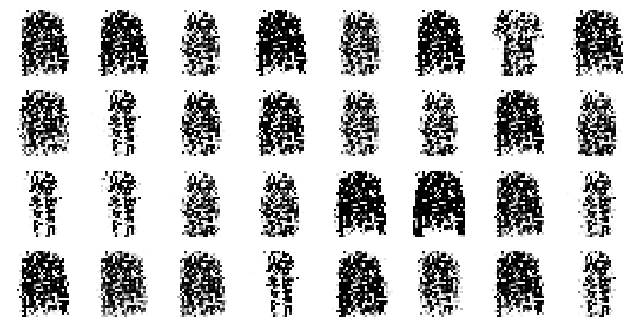

In [55]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"에포크 {epoch + 1}/{n_epochs}")  # 추가 코드
        for X_batch in dataset:
            # 1단계 - 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # 2단계 - 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # 추가 코드 - 훈련 중 이미지 출력
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

# 코랩에서 메모리 부족 에러를 피하기 위해 n_epochs를 50에서 10으로 바꿉니다.
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

#### GAN 훈련 반복 과정

각 훈련 반복에서 두 단계가 이루어집니다:

#### 1. 판별자 훈련
- **목표**: 생성자가 만든 가짜 이미지를 구분하고, 진짜 이미지를 정확하게 식별하는 것.
- **훈련 방법**:
  1. **가우스 잡음**을 생성자에 주입하여 **가짜 이미지**를 생성합니다.
  2. 생성된 가짜 이미지와 동일한 개수의 **진짜 이미지**를 합쳐 하나의 배치를 만듭니다.
  3. 이 배치에서 가짜 이미지에는 레이블 0을, 진짜 이미지에는 레이블 1을 할당합니다.
  4. 이 배치를 사용해 **판별자를 훈련**합니다. 이 단계에서는 **판별자만** 훈련되며, 생성자는 훈련되지 않습니다.

#### 2. 생성자 훈련
- **목표**: 판별자가 가짜 이미지를 진짜로 착각하게 만드는 것.
- **훈련 방법**:
  1. **가우스 잡음**을 생성자에 주입하여 **가짜 이미지**를 생성합니다.
  2. 생성된 가짜 이미지를 **판별자**에 전달하여 이 이미지가 진짜인지 가짜인지 추측하게 만듭니다.
  3. 이때, 생성자가 판별자가 **진짜라고 착각할 수 있도록** 이미지를 만듭니다.
  4. **타깃 레이블을 1로 설정**하여 판별자가 가짜 이미지를 진짜로 분류하도록 유도합니다.

  이 단계에서는 **생성자만** 훈련되고, 판별자는 훈련되지 않습니다.

훈련이 끝난 후에는 **가우스 분포에서 랜덤하게 샘플링한 코딩**을 생성자에 주입하여 새로운 이미지를 생성할 수 있습니다.


In [56]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

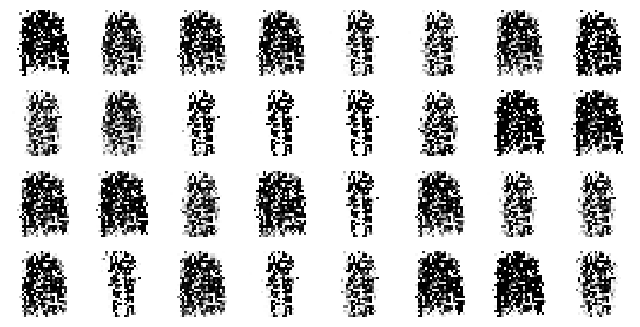

In [57]:
# 추가 코드 - 이 셀은 그림 17-15를 생성하고 저장합니다.
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

<img src="./images/fig17-15.png" width="100%"></img>

생성된 이미지 (그림 17-15)를 출력하면 첫 번째 에포크가 끝난 시점에서 이미 (잡음이 많지 
만) 패션 MNIST 이미지처럼 보이기 시작합니다.

### 17.8.1 GAN 훈련의 어려움

### GAN의 훈련과 내시 균형

#### 훈련 과정에서 생성자와 판별자
훈련 과정에서 생성자와 판별자는 서로를 속이려 끊임없이 경쟁합니다. 이는 **제로섬 게임**에 비유될 수 있으며, 훈련이 진행됨에 따라 **내시 균형(Nash equilibrium)**에 도달할 수 있습니다. 내시 균형이란, 다른 플레이어가 전략을 변경하지 않는 상태에서 각 플레이어가 자신의 전략을 수정하지 않으려는 상태를 의미합니다. 예를 들어, 모든 운전자가 도로 왼쪽으로 운전하는 상황이 내시 균형이 될 수 있습니다.

#### GAN에서 내시 균형
GAN의 내시 균형은 **생성자가 완벽하게 진짜와 같은 이미지를 만들어 판별자가 50%의 확률로만 진짜와 가짜를 구분할 수 있는 상태**에 도달할 때입니다. 이 상태는 GAN 훈련의 목표이며, 이 균형에 도달하면 생성자는 가짜 이미지를 더 이상 구분할 수 없게 됩니다. 그러나 훈련이 충분히 이루어져도 반드시 내시 균형에 도달한다고 보장할 수는 없습니다.

#### 모드 붕괴
**모드 붕괴(mode collapse)**는 GAN 훈련 중 발생할 수 있는 문제로, 생성자가 출력하는 이미지의 다양성이 줄어드는 현상입니다. 예를 들어, 생성자가 신발 이미지를 잘 만들어 판별자를 속일 수 있게 되면, 생성자는 점차 신발만 생성하게 되어 다른 이미지를 만드는 방법을 잊어버립니다. 결국, 생성자는 하나의 클래스만 생성하게 되고, 판별자는 다른 클래스에 대한 구별 능력을 상실하게 됩니다. 이런 현상이 반복되며 GAN은 어떤 클래스에서도 좋은 결과를 만들지 못할 수 있습니다.

#### 훈련의 불안정성과 하이퍼파라미터 조정
훈련이 시작될 때는 안정적이지만, 시간이 지나면서 GAN의 훈련이 불안정해져 발산할 수 있습니다. GAN의 하이퍼파라미터는 매우 민감하기 때문에 이를 미세 튜닝하기 위해 많은 노력과 시간이 필요합니다. 예를 들어, **Nadam** 옵티마이저 대신 **RMSProp**을 사용하는 것이 효과적일 수 있습니다. Nadam을 사용할 경우 모드 붕괴가 심해질 수 있습니다.

#### 안정적인 훈련을 위한 기법
- **경험 재생(Experience Replay)**: 생성자가 만든 이미지를 재생 버퍼에 저장하고, 실제 이미지와 재생된 가짜 이미지를 섞어 판별자를 훈련시키는 방법입니다. 이를 통해 판별자가 생성자의 최근 출력에 과대적합되지 않도록 도와줍니다.
- **미니배치 판별(Mini-batch discrimination)**: 배치 내 이미지들 간의 유사성을 측정하여 판별자에게 제공합니다. 이를 통해 판별자가 유사한 이미지를 쉽게 구분하지 않도록 유도하고, 생성자가 다양한 이미지를 생성하도록 합니다.

#### 연구 동향과 진전
GAN의 훈련은 여전히 활발히 연구되고 있으며, 아직 완벽하게 이해되지 않은 부분이 많습니다. 그러나 연구가 진행됨에 따라 많은 진전이 있었고, 일부 기법은 놀라운 성과를 거두었습니다. 가장 뛰어난 GAN 모델들 중 일부는 **심층 합성곱 GAN(Deep Convolutional GAN)**과 같은 모델입니다. 이와 함께 최신의 복잡한 GAN 구조들에 대한 연구도 계속해서 이루어지고 있습니다.


### 17.8.2 심층 합성곱 GAN

#### DCGAN: 심층 합성곱 GAN

2014년 GAN 논문에서 저자들은 합성곱 층을 사용한 실험을 진행했지만, 생성하는 이미지 크기가 작았습니다. 그 후 많은 연구자들이 큰 이미지를 생성하기 위해 더 깊은 합성곱 층을 사용하는 GAN을 개발하고자 했습니다. 하지만 훈련이 매우 불안정했기 때문에 구조가 까다로웠습니다. 2015년 **알렉 래드퍼드** 등은 여러 구조와 하이퍼파라미터 실험을 통해 성공적인 모델을 개발했습니다. 이 모델은 **심층 합성곱 GAN(Deep Convolutional GAN, DCGAN)**이라고 불립니다.

#### DCGAN을 구축하기 위한 주요 가이드라인

1. **풀링 층 대체**: 판별자의 풀링 층을 **스트라이드 합성곱(strided convolution)**으로 바꾸고, 생성자의 풀링 층을 **전치 합성곱(transposed convolution)**으로 바꿉니다.

2. **배치 정규화**: 생성자와 판별자의 배치 정규화(batch normalization)를 사용합니다. 다만, 생성자의 출력 층과 판별자의 입력 층에서는 배치 정규화를 사용하지 않습니다.

3. **완전 연결 은닉 층 제거**: 층을 깊게 쌓기 위해 **완전 연결 은닉 층(fully connected hidden layer)**을 제거합니다.

4. **활성화 함수 사용**: 생성자의 모든 층은 **ReLU 활성화 함수**를 사용하고, 출력 층은 **tanh 함수**를 사용합니다. 반면, 판별자의 모든 층은 **LeakyReLU 활성화 함수**를 사용합니다.

이 가이드라인은 대부분의 경우 유효하지만, 항상 그렇지는 않습니다. 따라서 여전히 다양한 하이퍼파라미터로 실험을 거쳐야 합니다. 실제로 **랜덤 시드(random seed)**만 바꾸고 같은 모델을 다시 훈련시키면 성공적인 결과를 얻기도 합니다.

### 패션 MNIST에서 작동하는 DCGAN 예시
다음은 패션 MNIST 데이터셋에서 잘 작동하는 작은 DCGAN 모델입니다.


In [58]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

#### DCGAN 생성자 설명

생성자는 크기가 100인 잠재 벡터(코딩)를 입력으로 받아, 이를 7x7x128 크기의 텐서로 변환합니다. 이 텐서는 다음 단계를 거쳐 이미지를 생성하게 됩니다.

1. **투영과 크기 변경**:
   - 생성자는 100차원의 코딩을 입력받아 7x7x128 크기의 텐서로 변환합니다. 이는 **배치 정규화(batch normalization)**가 적용된 후, **스트라이드 2인 전치 합성곱 층**에 입력됩니다.
   
2. **첫 번째 업샘플링**:
   - 7x7 텐서는 **전치 합성곱 층**을 통과하면서 14x14 크기로 업샘플링되고, 채널 수는 128에서 64로 감소합니다. 이 결과는 다시 배치 정규화가 적용된 후, 다음 단계로 넘어갑니다.

3. **두 번째 업샘플링**:
   - 14x14 크기의 텐서는 두 번째 **전치 합성곱 층**을 거치면서 28x28로 업샘플링되며, 채널 수는 64에서 1로 감소합니다. 이 층에서 사용되는 활성화 함수는 **tanh**로, 출력 범위는 -1에서 1 사이로 설정됩니다.

#### 훈련 전 준비
- 이 모델을 훈련하기 전에 훈련 세트의 이미지를 **-1에서 1 사이로 스케일링**해야 합니다.
- 또한, 이미지를 **크기를 비꾸고 채널 차원을 추가**하는 작업이 필요합니다.

이와 같은 구조는 DCGAN에서 사용되는 전형적인 생성자 구조로, 안정적인 훈련을 돕기 위해 여러 가지 기법들이 적용됩니다.


In [59]:
# 추가 코드 - 앞서와 같이 판별자와 gan을 컴파일합니다.
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [60]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # 크기 변경 및 스케일 조정

#### DCGAN 판별자 설명

DCGAN에서 판별자는 이진 분류를 위한 일반적인 CNN과 유사하지만 몇 가지 중요한 차이점이 있습니다.

1. **다운샘플링**:
   - 이미지를 다운샘플링할 때 **최대 풀링(max pooling)** 대신 **스트라이드 합성곱(strides=2)** 을 사용합니다. 이는 더 나은 훈련 성능을 위해 선택된 방식입니다.

2. **활성화 함수**:
   - 판별자의 각 층에서는 **LeakyReLU** 활성화 함수가 사용됩니다. 이는 ReLU의 변형으로, 음의 입력에 대해서도 일정 비율로 출력을 허용하여 "죽은 ReLU" 문제를 방지합니다.

3. **배치 정규화 대신 드롭아웃**:
   - DCGAN의 일반적인 가이드라인을 따르되, **배치 정규화(batch normalization)** 대신 **드롭아웃(dropout)** 층을 사용했습니다. 이는 훈련을 더 안정적이게 만드는데 도움이 되며, 이 예제에서는 드롭아웃을 적용하지 않으면 훈련이 불안정해질 수 있습니다.

#### 하이퍼파라미터 실험

- 이 구조를 실험하면서 하이퍼파라미터의 민감성을 확인할 수 있습니다. 특히 생성자와 판별자의 상대적인 **학습률(learning rate)**에 대한 민감도가 크므로 이를 잘 조정해야 합니다.

#### 훈련 결과

- 훈련 에포크가 50번 진행된 후 생성자는 실제와 유사한 이미지를 생성합니다. 완벽하지는 않지만, 대부분의 이미지는 상당히 그럴듯하게 생성됩니다. 
- 예를 들어, 훈련 후 생성된 이미지는 **［그림 17-16］**과 유사합니다.

DCGAN은 이미지 생성 분야에서 강력한 성능을 보여주는 모델로, 훈련 과정에서 다양한 기법을 적용하여 훈련 안정성과 성능을 향상시킬 수 있습니다.


에포크 1/1


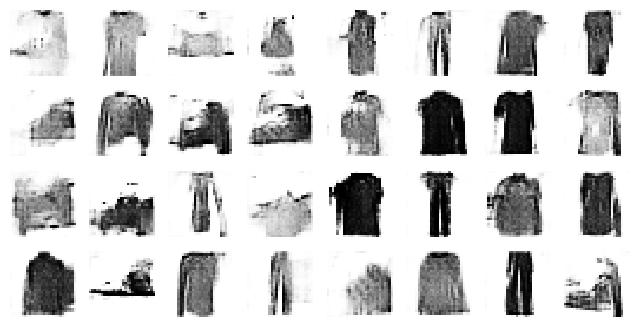

In [61]:
# 추가 코드 - 앞서와 마찬가지로 데이터셋을 생성하고 GAN을 학습시킵니다.
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
# 코랩에서 메모리 부족 에러를 피하기 위해 n_epochs를 50에서 10으로 바꿉니다.
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

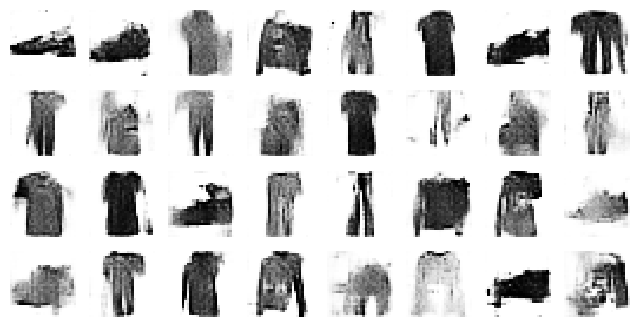

In [62]:
# 추가 코드 - 이 셀은 그림 17-16을 생성하고 저장합니다.
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

<img src="./images/fig17-16.png" width="100%"></img>

## 17.9 확산 모델

#### 확산 모델 (Diffusion Models)

확산 모델은 오랜 역사를 가지고 있지만, 2015년에 스탠포드 대학교와 UC 버클리의 연구자들인 야샤 솔딕스타인(Yasha Sohl-Dickstein) 등이 제안한 논문에서 현대적인 형태로 발전하였습니다. 그들의 핵심 아이디어는 차에 우유를 혼합하는 과정처럼 이미지를 점차적으로 "혼합 해제"하는 역방향 과정을 학습하는 것입니다. 이 아이디어를 사용하여 이미지 생성에 유망한 결과를 얻었지만, 당시에는 GAN이 더 설득력 있는 결과를 보였기 때문에 확산 모델은 큰 주목을 받지 못했습니다.

#### DDPM (Denoising Diffusion Probabilistic Models)

2020년에 UC 버클리의 연구자 조나단 호(Jonathan Ho)와 팀은 **DDPM**(잡음 제거 확산 확률 모델)을 개발하여 GAN보다 더 사실적인 이미지를 생성하는 데 성공했습니다. DDPM은 GAN보다 훈련이 더 쉬우며, 생성되는 이미지의 품질이 매우 뛰어난 장점이 있지만, 생성 속도가 상대적으로 느리다는 단점이 있습니다.

#### 정방향 확산과정 (Forward Process)

DDPM에서 이미지는 점진적으로 **가우시안 잡음**이 추가되는 과정을 거칩니다. 예를 들어, 고양이 이미지를 사용한다고 할 때, 각 타임스텝마다 고양이에 점점 더 많은 잡음이 추가됩니다. 처음에는 고양이의 형태가 점차 희미해지고, 결국 마지막 타임스텝에서는 이미지가 완전히 잡음으로 가려져 보이지 않게 됩니다.

- **정방향 과정**에서 각 타임스텝에서 추가되는 잡음은 **등방성(isotropic)** 가우시안 잡음입니다. 각 픽셀마다 독립적인 잡음이 추가되며, 이 과정을 반복하면서 이미지의 분산이 1에 가까워지도록 합니다.
- 고양이 이미지를 타겟으로 할 때, 각 타임스텝에서 **픽셀 값**은 점차 0으로 수렴하고, **분산**은 1로 수렴하게 됩니다.

#### 정방향 확산의 수학적 표현

정방향 확산 과정은 수학적으로 **가우시안 분포**의 변화를 나타냅니다. 식 17-5는 각 타임스텝에서 이미지가 어떻게 변하는지에 대한 확률 분포를 나타냅니다. 이때 잡음의 분포는 평균이 0이고, 분산이 1인 가우시안 분포로 정의됩니다.

<img src="./images/eq17-05.png" width="100%"></img>

정방향 과정에서 가우시안 잡음의 추가는 **지름길**을 통해 한 번에 모든 잡음을 추가하는 방식으로 구현될 수 있습니다. 이는 계산 속도를 빠르게 해주며, 전체 과정을 효율적으로 처리할 수 있게 합니다(식 17-6 참조).

<img src="./images/eq17-06.png" width="100%"></img>

#### 역방향 과정 (Reverse Process)

DDPM의 핵심은 정방향 과정에서 이미지를 점차 잡음으로 덮은 후, **역방향 과정**을 통해 잡음을 점차 제거하여 새로운 이미지를 생성하는 것입니다. 이 역방향 과정은 훈련된 모델을 통해 점진적으로 잡음을 제거하면서, 고양이 이미지를 생성하는 방식으로 작동합니다. 훈련된 모델은 가우시안 잡음이 추가된 이미지를 받아들여 점차 새로운 고양이 이미지를 생성합니다.

이러한 방식으로 **DDPM**은 GAN을 능가하는 사실적인 이미지를 생성하는 능력을 보여주었으며, 특히 **이미지 생성의 품질**과 **다양성**에서 두각을 나타냈습니다.

물론 우리의 목표는 고양이를 잡음으로 뒤덮는 것이 아닙니다. 오히려 새로운 고양이를 많이 
만들어야 합니다! 이를 위해 $x_t$ 에서 $x_{t-1}$에서 유로 가는 역방향 과정을 수행할 수 있는 모델을 훈련시키면 됩니다. 그런 다음 이 모델을 사용하여 이미지에서 작은 잡음을 제거하고 모든 잡음이 사라질 때까지 이 작업을 여러 번 반복합니다. 

고양이 이미지가 많이 포함된 데이터셋에서 모델을 훈련시킨 다음 가우스 잡음으로 가득 찬 사진을 제공하면 모델이 점차 새로운 고양이가 나타나게 만들 것입니다（그림 17-20）

<img src="./images/fig17-20.png" width="100%"></img>

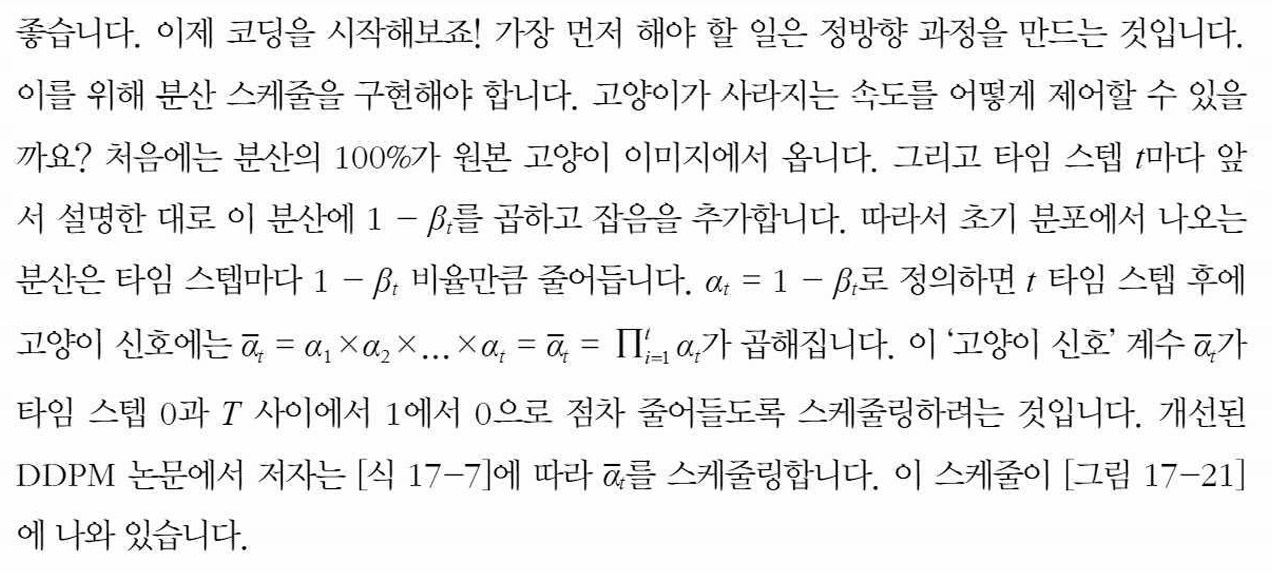

<img src="./images/eq17-07.png" width="100%"></img>

<img src="./images/fig17-21.png" width="100%"></img>

데이터셋의 이미지로 시작하여 각 타임 스텝 $t$에서 확산 과정은 평균 0, 분산 $\beta_t$의 가우스 잡음을 추가합니다. 그런 다음 모델은 이 프로세스를 역으로 수행하도록 훈련됩니다. 보다 구체적으로, 정방향 과정에 의해 생성된 잡음 이미지와 시간 $t$가 주어지면 모델은 분산 1로 스케일링된 원본 이미지에 추가된 총 잡음을 예측하도록 훈련됩니다.

[DDPM 논문](https://arxiv.org/abs/2006.11239)에서는 $\beta_1$ = 0.0001에서 $\beta_T = $0.02($T$가 최대 스텝)로 $\beta_t$를 늘렸지만, [개선된 DDPM 논문](https://arxiv.org/pdf/2102.09672.pdf)에서는 $\bar{\alpha_t} = \prod_{i=0}^{t}$를 점차적으로 감소시키는 다음과 같은 $\cos^2(\ldots)$ 스케줄 사용을 제안했습니다. $\alpha_i$ 를 1에서 0으로, 여기서 $\alpha_t = 1 - \beta_t$ 로 점차 감소시킵니다:

In [63]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # 추가 코드 - 재현성을 위한
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

DDPM 논문에서 저자들은 $T = 1,000$을 사용했지만, 개선된 DDPM에서는 이 값을 $T = 4,000$으로 늘렸기 때문에 이 값을 사용합니다. `alpha` 변수는 $\alpha_0, \alpha_1, ..., \alpha_T$를 포함하는 벡터입니다. 변수 `alpha_cumprod`는 $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$를 포함하는 벡터입니다.

`alpha_cumprod`을 그래프로 그려보죠:

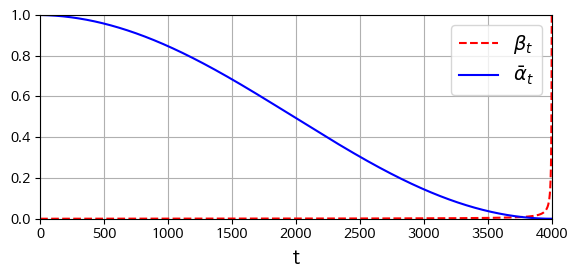

In [64]:
# 추가 코드 - 이 셀은 그림 17-21을 생성하고 저장합니다.
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
save_fig("variance_schedule_plot")
plt.show()

확산 과정을 거꾸로 수행하도록 모델을 훈련하려면 정방향 과정의 여러 타임 스텝에서 추출한 
잡음 섞인 이미지가 필요합니다. 데이터셋에서 깨끗한 이미지의 배치를 가져와 이런 이미지를 
만드는 prepare_batch() 함수를 만들어보겠습니다

`prepare_batch()` 함수는 이미지 배치를 가져와 각 이미지에 대해 1에서 $T$ 사이의 다른 임의 시간을 사용하여 각 이미지에 잡음을 추가하고 입력과 타겟을 포함하는 튜플을 반환합니다:

* 입력은 잡음이 있는 이미지와 해당 시간이 포함된 `dict`입니다. 이 함수는 DDPM 논문의 방정식 (4)를 사용하여 원본 이미지에서 직접 노이즈가 있는 이미지를 한 번에 계산합니다. 이는 정방향 확산 과정의 지름길입니다.
* 타깃은 잡음 이미지를 생성하는 데 사용된 잡음입니다.

In [65]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # -1에서 +1까지 스케일링
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

### 패션 MNIST 데이터 처리 및 확산 과정 적용
이 코드는 패션 MNIST 데이터를 처리하고, 확산 과정을 적용하기 위한 단계별 설명입니다.

#### 1. 채널 축 추가
- 패션 MNIST 데이터를 사용하기 위해 먼저 채널 축을 추가합니다. 이를 통해 이미지의 형태가 (배치 크기, 높이, 너비, 채널)로 변경됩니다.

#### 2. 픽셀 값 스케일 조정
- 픽셀 값을 -1에서 1로 스케일 조정합니다. 이를 통해 최종 가우스 분포에 가까운 평균이 0이고 분산이 1인 이미지로 만듭니다.

#### 3. 랜덤 타임 스텝 생성
- 각 배치의 이미지에 대해 1에서 T 사이의 임의의 타임 스텝을 포함하는 벡터 `t`를 생성합니다.

#### 4. alpha_cumprod 값 추출
- `tf.gather`를 사용하여 벡터 `t`의 각 타임 스텝에 대한 `alpha_cumprod` 값을 추출합니다. 
- 이를 통해 각 이미지에 대해 `alpha_cm` 값이 하나씩 포함된 벡터가 만들어집니다.

#### 5. alpha_cm의 크기 조정
- `alpha_cm`을 [배치 크기]에서 [배치 크기, 1, 1, 1]로 크기를 조정합니다. 
- 이는 배치 X에 `alpha_cm`을 브로드캐스팅하기 위해 필요합니다.

#### 6. 가우스 잡음 생성
- 평균이 0이고 분산이 1인 가우스 잡음을 생성합니다.

#### 7. 확산 과정 적용
- [식 17-6]을 사용하여 이미지에 확산 과정을 적용합니다. 
- `x ** 0.5`는 x의 제곱근을 의미합니다.
- 이 함수는 입력과 타깃을 포함하는 튜플을 반환합니다. 
  - **입력:** 잡음 이미지와 이미지 생성에 사용된 타임 스텝이 포함된 파이썬 딕셔너리.
  - **타깃:** 각 이미지를 생성하는 데 사용된 가우스 잡음.

이 과정을 통해 패션 MNIST 이미지를 처리하고, 필요한 확산 과정을 적용할 수 있습니다.

그다음 훈련 데이터셋과 검증 데이터셋을 만들고 모든 배치에 prepare_batch() 함수를 적용 
하겠습니다. 이전처럼 X_train과 X_valid에는 픽셀값이 0에서 1 사이인 패션 MNIST 이미 
지가 담겨있습니다.

이제 훈련과 검증을 위한 `tf.data.Dataset`을 준비합니다.

In [66]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # 추가 코드 - CPU에서 재현성 보장
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

간단한 모델 상태를 확인하기 위해 몇 가지 훈련 샘플과 예측할 잡음, 원본 이미지(적절하게 스케일링된 잡음 이미지에서 적절하게 스케일링된 잡음을 빼서 얻은 이미지)를 살펴 보겠습니다:

원본 이미지


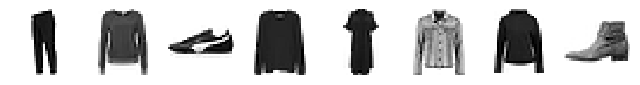

타임 스텝: [3405  312 3441 1991 2443 1657 3308 1151]
잡음 이미지


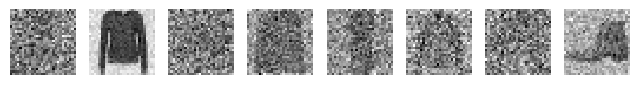

예측할 잡음


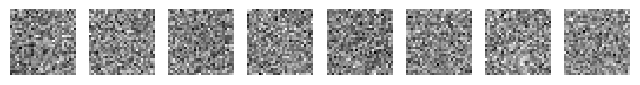

In [67]:
# 추가 코드 - 간단한 데이터 검증

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("원본 이미지")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("타임 스텝:", X_dict["time"].numpy()[:8])
print("잡음 이미지")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("예측할 잡음")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

이제 확산 모델 자체를 구축할 준비가 되었습니다. 이미지와 시간을 모두 처리해야 합니다. DDPM 논문에서 제안한 대로 [트랜스포머](https://arxiv.org/abs/1706.03762) 논문에서처럼 사인파 인코딩을 사용하여 시간을 인코딩합니다. 시간 인덱스(정수)를 나타내는 _m_ 정수의 벡터가 주어지면 이 층은 _m_ × _d_ 행렬을 반환하며, 여기서 _d_는 선택한 임베딩 크기입니다.

In [68]:
# 추가 코드 - 사용자 정의 시간 인코딩 층을 구현합니다.

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

이제 모델을 빌드해 보겠습니다. 개선된 DDPM 문서에서는 UNet 모델을 사용합니다. `Conv2D` + `BatchNormalization` 층을 통해 이미지를 처리하고 스킵 연결을 가진 UNet과 유사한 모델을 만들어 보겠습니다. 점차적으로 이미지 다운샘플링(`strides=2`인 `MaxPooling` 층을 사용)한 다음 다시 업샘플링합니다(`Upsampling2D` 층 사용). 다운샘플링 부분과 업샘플링 부분에 스킵 연결이 추가됩니다. 또한 `Dense` 레이어를 통과하여 올바른 크기로 크기를 조정한 후 각 블록의 출력에 시간 인코딩을 추가합니다.

* **참고**: 이미지의 시간 인코딩은 마지막 축(채널)을 따라 이미지의 모든 픽셀에 추가됩니다. 따라서 `Conv2D` 층의 유닛 수는 임베딩 크기와 일치해야 하며, `time_enc` 텐서를 재구성하여 너비 및 높이 차원을 추가해야 합니다.
* 이 UNet 구현은 keras.io의 [이미지 분할 예제](https://keras.io/examples/vision/oxford_pets_image_segmentation/)와 [공식 확산 모델 구현](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py)을 참고했습니다. 첫 번째 구현과 비교하여 몇 가지를 추가했는데, 특히 시간 인코딩과 다운/업 부분의 스킵 연결이 추가되었습니다. 두 번째 구현과 비교하여 몇 가지 사항, 특히 주의 레이어를 제거했습니다. 패션 MNIST에는 과한 것 같지만 자유롭게 추가할 수 있습니다.

In [69]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # 시간 인코딩 적용
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # 모든 픽셀에 시간 데이터 추가

    skip = Z
    cross_skips = []  # UNet의 다운샘플링 & 업샘플링을 가로지르는 스킵 연결

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

모델을 훈련시켜 봅시다!

In [70]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# 추가 코드 - 모델 체크포인트 콜백을 추가합니다.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=1,
                    callbacks=[checkpoint_cb])  # 추가 코드

1719/1719 [==============================] - ETA: 0s - loss: 0.1120WARNING:tensorflow:From d:\00_Python_Projects\01_Study\user_ds4th_study\source\핸즈온_머신러닝\.tensor0\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_diffusion_model\assets
1719/1719 [==============================] - 304s 177ms/step - loss: 0.1120 - val_loss: 0.0720


모델이 훈련되면 이를 사용하여 새 이미지를 생성할 수 있습니다. 이를 위해 가우스 잡음을 생성하고 이것이 시간 $T$ 동안의 확산 과정의 결과라고 가정합니다. 그런 다음 모델을 사용하여 $T - 1$ 시점의 이미지를 예측한 다음 다시 호출하여 $T - 2$를 구하는 식으로 각 단계에서 약간의 노이즈를 제거합니다. 마지막으로 패션 MNIST 데이터셋에서 가져온 것처럼 보이는 이미지를 얻습니다. 이 역방향 과정에 대한 방정식은 DDPM 논문 4페이지 상단에 있습니다(알고리즘 2의 4단계).

모델을 훈련하고 나면 이를 사용하여 새로운 이미지를 생성할 수 있습니다. 안타깝게도 역방향 
확산 과정에는 지름길이 없습니다. 따라서 평균이 0이고 분산이 1 인 가우스 분포에서 $x_T$를 랜 
덤으로 샘플링한 다음 모델에 전달하여 잡음을 예측합니다. 그다음 ［식 17-8］을 사용하여 이 
미지에서 잡음을 빼면 $x_{T-1}$이 됩니다. $x_0$이 될 때까지 이 과정을 3,999번 더 반복합니다. 모든 것이 잘 되었다면 일반적인 패션 MNIST 이미지처럼 보일 것입니다!

<img src="./images/eq17-08.png" width="100%"></img>

이 역방향 과정을 구현하는 함수를 작성하고 이를 호출하여 몇 개의 이미지를 생성해보겠습니다.

In [71]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # 추가 코드 - 진행률 표시
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
X_gen = generate(model)  # 생성된 이미지

t = 1    

이미지 생성에 1〜2분 정도 걸릴 수 있습니다. 이것이 확산 모델의 주요한 단점입니다. 모델을 
여러 번 호출해야 하므로 이미지 생성 속도가 느립니다. 더 작은 T 값을 사용하거나 한 번에 여 
러 단계에 걸쳐 동일한 모델 예측을 사용하면 속도를 높일 수 있지만 결과 이미지가 좋지 않을 
수 있습니다. 하지만 이러한 속도 제한에도 불구하고 확산 모델은 [그림 17-22] 와 같이 고품 
질의 다양한 이미지를 생성합니다.

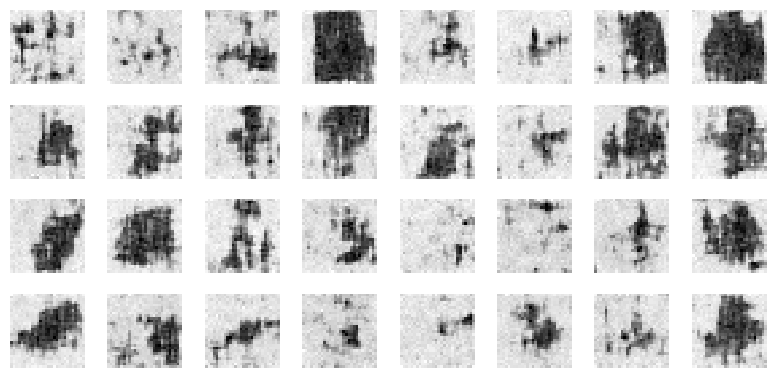

In [72]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("ddpm_generated_images_plot")
plt.show()

<img src="./images/fig17-22.png" width="100%"></img>

이 이미지 중 일부는 정말 설득력이 있습니다! 확산 모델은 GAN에 비해 더 다양한 이미지를 생성하는 경향이 있으며, 이미지 품질에서도 GAN을 능가합니다. 또한 훈련이 훨씬 더 안정적입니다. 하지만 이미지를 생성하는 데는 시간이 훨씬 더 오래 걸립니다.

### 확산 모델의 발전

확산 모델은 최근 크게 발전하였으며, 특히 2021년 12월에 로빈 롬바흐(Robin Rombach)와 안드레아스 블랫만(Andreas Blattmann) 등의 연구에 의해 **잠재 확산 모델(latent diffusion model)**이 소개되었습니다. 이 모델은 확산 과정이 픽셀 공간이 아닌 **잠재 공간**에서 일어나는 방식입니다.

모델의 특징
- **오토인코더**를 사용하여 훈련 이미지를 더 작은 잠재 공간으로 압축하고, 그 후 확산 과정을 통해 이미지를 생성합니다.
- 이 방식은 이미지 생성 속도를 크게 향상시키고, 훈련 시간과 비용을 줄여줍니다.
- 생성된 이미지의 품질이 매우 뛰어납니다.

확산 과정의 가이드
- **텍스트 프롬프트, 이미지, 기타 입력**을 사용하여 확산 과정을 가이드하는 다양한 **조건 부여 기법**이 적용되었습니다.
- 이를 통해 다양한 이미지를 빠르게 생성할 수 있으며, 예를 들어 **책을 읽고 있는 도롱뇽**과 같은 고해상도 이미지를 생성할 수 있습니다.
- **입력 이미지**를 사용하여 생성 프로세스를 제어할 수 있으며, **아웃페인팅**(outpainting)과 **인페인팅**(inpainting) 등의 기능을 구현할 수 있습니다.

오픈 소스 공개
- 2022년 8월, **스테이블 디퓨전(Stable Diffusion)** 모델이 **EleutherAI**와 **LAION**의 지원을 받아 **뮌헨 공과대학교**, **StabilityAI**, **Runway** 등과 협력하여 오픈 소스로 공개되었습니다.
- 2022년 9월, 이 모델은 **텐서플로(TensorFlow)**로 포팅되어 **KerasCV** 라이브러리에 포함되었습니다.
- 이제 누구나 **일반 노트북**에서 무료로 몇 초 만에 놀라운 이미지를 생성할 수 있습니다.

결론
이 모델의 발전으로 이미지 생성의 가능성은 무한히 확장되었습니다. 이후, **심층 강화 학습**에 대해 살펴보겠습니다.


## 추가 자료 - 이진 오토인코더를 사용한 해싱

인코더에 16개의 뉴런으로 구성된 출력 층과 시그모이드 활성화 함수를 사용하고 바로 그 전에 가우스 잡음을 추가한 오토인코더를 훈련해 보겠습니다. 훈련 중에 잡음 층은 이전 층이 큰 값을 출력하도록 권장합니다. 작은 값은 잡음에 의해 희석되기 때문입니다. 그리고 시그모이드 활성화 함수 덕분에 출력 층이 0 또는 1에 가까운 값을 출력하게 됩니다. 출력 값을 0과 1로 반올림하면 16비트 "시맨틱" 해시를 얻을 수 있습니다. 모든 것이 잘 작동하면 비슷해 보이는 이미지의 해시값이 동일합니다. 이는 검색 엔진에 매우 유용할 수 있습니다: 예를 들어 이미지의 시맨틱 해시로 식별되는 서버에 각 이미지를 저장하면 유사한 이미지가 모두 같은 서버에 저장됩니다. 검색 엔진 사용자가 검색할 이미지를 제공하면 검색 엔진이 인코더를 사용하여 이미지의 해시를 계산하고 해당 해시로 식별되는 서버의 모든 이미지를 신속하게 반환합니다.

In [73]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0542 - val_loss: 0.0552
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0422 - val_loss: 0.0496
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0390 - val_loss: 0.0424
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0370 - val_loss: 0.0411
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0359 - val_loss: 0.0390
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0350 - val_loss: 0.0373
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0345 - val_loss: 0.0366
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0338 - val_loss: 0.0356
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0333 - val_loss: 0.0338
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.032

이 오토인코더는 정보를 너무 많이 압축하여(16비트까지!) 손실이 크지만 괜찮습니다. 이미지를 완벽하게 재구성하는 것이 아니라 시맨틱 해시를 생성하는 데 사용하므로 괜찮습니다:

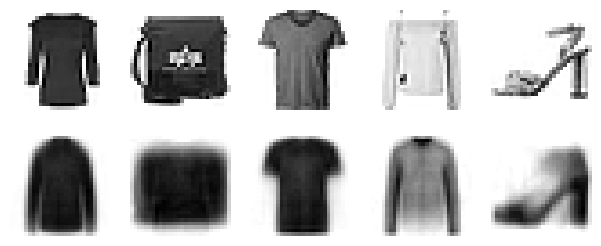

In [74]:
plot_reconstructions(hashing_ae)
plt.show()

이제 검증 세트의 처음 몇 개의 이미지에 대한 해시가 어떻게 보이는지 살펴보겠습니다:

In [75]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

0110110110111011
1100110101111011
1110100110111011
0101111000111000
1001110101101001
...


이제 유효성 검사 집합에서 가장 일반적인 이미지 해시를 찾고 각 해시에 대해 몇 개의 이미지를 표시해 보겠습니다. 다음 이미지에서는 주어진 행에 있는 모든 이미지의 해시가 동일합니다:

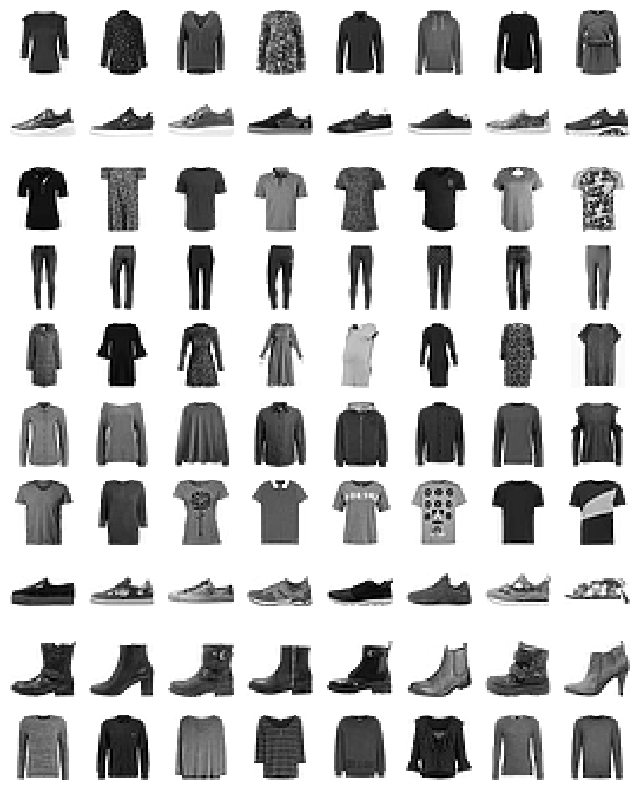

In [76]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()

## 연습문제 해답

## 1. to 8.

부록 A 참조

## 10.
_문제: 잡음 제거 오토인코더를 사용해 이미지 분류기를 사전훈련해보세요. (간단하게) MNIST를 사용하거나 도전적인 문제를 원한다면 CIFAR10 같은 좀 더 복잡한 이미지 데이터셋을 사용할 수 있습니다. 어떤 데이터셋을 사용하던지 다음 단계를 따르세요._

* 데이터셋을 훈련 세트와 테스트 세트로 나눕니다. 전체 훈련 세트에서 심층 잡음 제거 오토인코더를 훈련합니다.
* 이미지가 잘 재구성되는 지 확인하세요. 코딩 층의 각 뉴런을 가장 크게 활성화하는 이미지를 시각화해보세요.
* 이 오토인코더의 아래 층을 재사용해 분류 DNN을 만드세요. 훈련 세트에서 이미지 500개만 사용해 훈련합니다. 사전훈련을 사용하는 것이 더 나은가요? 사용하지 않는 것이 더 나은가요?

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
tf.random.set_seed(42)

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
])

In [ ]:
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [ ]:
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam",
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

In [ ]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()

## 11.
_문제: 이미지 데이터셋을 하나 선택해 변이형 오토인코더를 훈련하고 이미지를 생성해보세요. 또는 관심있는 레이블이 없는 데이터셋을 찾아서 새로운 샘플을 생성할 수 있는지 확인해 보세요._

VAE 코드 참조

## 12.
_문제: 이미지 데이터셋을 처리하는 DCGAN을 훈련하고 이를 사용해 이미지를 생성해보세요. 경험 재생을 추가하고 도움이 되는지 확인하세요. 생성된 클래스를 제어할 수 있는 조건 GAN으로 바꾸어 시도해보세요._

TODO